# Random Forest Model Training and Evaluation

## 1 Import libraries

In [16]:
print("Loading libraries...")

# Data manipulation libraries
import pandas as pd
import numpy as np

# Load .npz sparse matrices
from scipy.sparse import load_npz

# For saving/loading sklearn models and the vectoriser
import joblib

# Scikit-learn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # For hyperparameter tuning
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

# For plotting confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

# Download feature files from Google Drive
import gdown

# Core libraries
import os
import time

print("Libraries loaded.")

Loading libraries...
Libraries loaded.


## 2 Load engineered features and labels

Load the `X_train_features.npz`, `X_val_features.npz`, `X_test_features.npz` (sparse matrices for TF-IDF features),
and their corresponding label files (`y_train_labels.csv`, `y_val_labels.csv`, `y_test_labels.csv`).
Also, load the saved `tfidf_vectorizer.joblib` as it might be needed later for XAI or processing other test sets.

In [17]:
# --- Define Google Drive File IDs and local filenames ---

# Feature files (.npz)
X_TRAIN_GDRIVE_FILE_ID = '1qNmaeG04PRDuwhtqyOxGfpXHBE4fNAV4'
X_TRAIN_LOCAL_FILENAME = 'X_train_features.npz'

X_VAL_GDRIVE_FILE_ID = '1REX920Oyw5sd5d1_crZgfh38AEjtfQhE'
X_VAL_LOCAL_FILENAME = 'X_val_features.npz'

X_TEST_GDRIVE_FILE_ID = '1Uy8XTpCQRV5CckNj3EmfbXcIDFD3OSff'
X_TEST_LOCAL_FILENAME = 'X_test_features.npz'

# Label files (.csv)
Y_TRAIN_GDRIVE_FILE_ID = '1cIg52jAE_UHeUao_LZom8VTVXrEdRsTK'
Y_TRAIN_LOCAL_FILENAME = 'y_train_labels.csv'

Y_VAL_GDRIVE_FILE_ID = '1P1mHzuMjk5sCpTN4Huyw4ps2nr6fEMGX'
Y_VAL_LOCAL_FILENAME = 'y_val_labels.csv'

Y_TEST_GDRIVE_FILE_ID = '1qvdVxKBSfRdUzjeHX6iQUpxAOMPbulYD'
Y_TEST_LOCAL_FILENAME = 'y_test_labels.csv'

# TF-IDF Vectorizer (.joblib)
VECTORIZER_GDRIVE_FILE_ID = '1JioXYHa5Roi4WxacfSJWa4LXPJPzltFA'
VECTORIZER_LOCAL_FILENAME = 'tfidf_vectorizer.joblib'

# --- List of files to download ---
files_to_download = [
    {'id': X_TRAIN_GDRIVE_FILE_ID, 'name': X_TRAIN_LOCAL_FILENAME},
    {'id': Y_TRAIN_GDRIVE_FILE_ID, 'name': Y_TRAIN_LOCAL_FILENAME},
    {'id': X_VAL_GDRIVE_FILE_ID, 'name': X_VAL_LOCAL_FILENAME},
    {'id': Y_VAL_GDRIVE_FILE_ID, 'name': Y_VAL_LOCAL_FILENAME},
    {'id': X_TEST_GDRIVE_FILE_ID, 'name': X_TEST_LOCAL_FILENAME},
    {'id': Y_TEST_GDRIVE_FILE_ID, 'name': Y_TEST_LOCAL_FILENAME},
    {'id': VECTORIZER_GDRIVE_FILE_ID, 'name': VECTORIZER_LOCAL_FILENAME}
]

# --- Function to download with gdown if file doesn't exist ---
# (Ensure gdown is imported in Section 1: import gdown)
def download_file_from_gdrive(file_id, local_filename):
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename} from Google Drive...")
        gdrive_url = f'https://drive.google.com/uc?id={file_id}'
        try:
            gdown.download(gdrive_url, local_filename, quiet=False)
            print(f"{local_filename} downloaded successfully.")
        except Exception as e:
            print(f"ERROR downloading {local_filename}: {e}. Check File ID and share settings.")
            return False
    else:
        print(f"{local_filename} already exists in Colab runtime.")
    return os.path.exists(local_filename)

# --- Download all necessary files ---
all_files_available = True
for file_info in files_to_download:
    if not download_file_from_gdrive(file_info['id'], file_info['name']):
        all_files_available = False
        break # Stop if any file fails to download

# --- Initialize variables ---
X_train, y_train = None, None
X_val, y_val = None, None
X_test, y_test = None, None
tfidf_vectorizer = None

if all_files_available:
    try:
        print(f"\nLoading training features from {X_TRAIN_LOCAL_FILENAME}...")
        X_train = load_npz(X_TRAIN_LOCAL_FILENAME)
        y_train_df = pd.read_csv(Y_TRAIN_LOCAL_FILENAME)
        y_train = y_train_df['label'].values
        print(f"Training data loaded: X_train shape {X_train.shape}, y_train shape {y_train.shape}")

        print(f"\nLoading validation features from {X_VAL_LOCAL_FILENAME}...")
        X_val = load_npz(X_VAL_LOCAL_FILENAME)
        y_val_df = pd.read_csv(Y_VAL_LOCAL_FILENAME)
        y_val = y_val_df['label'].values
        print(f"Validation data loaded: X_val shape {X_val.shape}, y_val shape {y_val.shape}")

        print(f"\nLoading test features from {X_TEST_LOCAL_FILENAME}...")
        X_test = load_npz(X_TEST_LOCAL_FILENAME)
        y_test_df = pd.read_csv(Y_TEST_LOCAL_FILENAME)
        y_test = y_test_df['label'].values
        print(f"Test data loaded: X_test shape {X_test.shape}, y_test shape {y_test.shape}")

        print(f"\nLoading TF-IDF vectorizer from {VECTORIZER_LOCAL_FILENAME}...")
        tfidf_vectorizer = joblib.load(VECTORIZER_LOCAL_FILENAME)
        print("TF-IDF vectorizer loaded.")

        print("\nAll data and vectorizer loaded successfully.")

    except FileNotFoundError as e:
        print(f"ERROR: File not found after download attempt - {e.filename}. This shouldn't happen if download was successful.")
        all_files_available = False # Mark as not loaded
    except Exception as e:
        print(f"An error occurred during data loading from local files: {e}")
        all_files_available = False # Mark as not loaded
else:
    print("\nOne or more files could not be downloaded. Cannot proceed with model training.")

X_train_features.npz already exists in Colab runtime.
y_train_labels.csv already exists in Colab runtime.
X_val_features.npz already exists in Colab runtime.
y_val_labels.csv already exists in Colab runtime.
X_test_features.npz already exists in Colab runtime.
y_test_labels.csv already exists in Colab runtime.
tfidf_vectorizer.joblib already exists in Colab runtime.

Loading training features from X_train_features.npz...
Training data loaded: X_train shape (29280, 15000), y_train shape (29280,)

Loading validation features from X_val_features.npz...
Validation data loaded: X_val shape (6274, 15000), y_val shape (6274,)

Loading test features from X_test_features.npz...
Test data loaded: X_test shape (6275, 15000), y_test shape (6275,)

Loading TF-IDF vectorizer from tfidf_vectorizer.joblib...
TF-IDF vectorizer loaded.

All data and vectorizer loaded successfully.


## 3 Model training (Random Forest)

Train a Random Forest classifier on the training data (`X_train`, `y_train`) woth some default parameters, that will be tuned later.

In [18]:
model_rf = None # Initialize

if all_files_available and X_train is not None and y_train is not None:
    print(f"Training Random Forest classifier on {X_train.shape[0]} samples...")
    start_time_train = time.time()

    # Initialize Random Forest Classifier
    # These are example parameters, can be tuned in the next section
    model_rf = RandomForestClassifier(
        n_estimators=150,     # Number of trees in the forest
        max_depth=None,       # Expand nodes until all leaves are pure or contain min_samples_split
        min_samples_split=5,  # Minimum number of samples required to split an internal node
        min_samples_leaf=2,   # Minimum number of samples required to be at a leaf node
        random_state=42,
        class_weight='balanced_subsample', # Good for balanced or slightly imbalanced data, adjusts weights per tree
        n_jobs=-1             # Use all available cores
    )

    model_rf.fit(X_train, y_train)
    train_duration = time.time() - start_time_train
    print(f"Random Forest training completed in {train_duration:.2f} seconds.")

    # Evaluate on training data (to check for severe overfitting, but test/val is more important)
    y_train_pred_rf = model_rf.predict(X_train)
    train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
    print(f"Training Accuracy (Random Forest): {train_accuracy_rf:.4f}")

else:
    print("Training data not available. Skipping model training.")

Training Random Forest classifier on 29280 samples...
Random Forest training completed in 24.82 seconds.
Training Accuracy (Random Forest): 0.9904


## 4 Hyperparameter tuning

Use GridSearchCV or RandomizedSearchCV to find better hyperparameters for the Random Forest model using the validation set (`X_val`, `y_val`).

In [19]:
# Set to True to run hyperparameter tuning, False to skip and use trained base model
RUN_HYPERPARAMETER_TUNING = True

best_model_rf = model_rf

if RUN_HYPERPARAMETER_TUNING and model_rf is not None and X_val is not None and y_val is not None:
    print("Starting Hyperparameter Tuning for Random Forest...")
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 30, 50],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4],
        'criterion': ['gini', 'entropy']
    }

    # Using GridSearchCV - can be slow. RandomizedSearchCV is faster for larger search spaces.
    # For GridSearchCV, cv=3 is a common choice for cross-validation folds.
    # Scoring: 'f1_weighted' is good for classification, 'roc_auc' is also common.
    grid_search_rf = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_jobs=-1),
        param_grid=param_grid_rf,
        cv=3, # 3-fold cross-validation on the validation set for tuning
        scoring='f1_weighted', # Focus on F1-score
        verbose=2, # Shows progress
        n_jobs=-1  # Use all available cores for GridSearchCV itself
    )

    print("Fitting GridSearchCV on validation data (X_val, y_val)...")
    # Note: For proper CV during tuning, you'd typically fit GridSearchCV on X_train,
    # and the CV process splits X_train further.
    # Here, using X_val directly for a simpler tuning setup IF X_train was already large.
    # A more robust approach is to combine X_train and X_val for GridSearchCV if X_val is small,
    # or just fit GridSearchCV on X_train and evaluate final on X_test.
    # For this project's timeline, fitting on X_val to find params for a final model trained on X_train can be a pragmatic shortcut.
    # Let's refine: Fit on training data, evaluate best params on validation.

    # Fit GridSearchCV on the *training data*
    # The internal CV of GridSearchCV will use portions of X_train for its own validation.
    grid_search_rf.fit(X_train, y_train) # Fit on the full training set

    print("\nBest parameters found by GridSearchCV:")
    print(grid_search_rf.best_params_)

    best_model_rf = grid_search_rf.best_estimator_ # This is the retrained model with best params

    print("\nEvaluating tuned model on validation set (X_val, y_val):")
    y_val_pred_tuned_rf = best_model_rf.predict(X_val)
    val_accuracy_tuned_rf = accuracy_score(y_val, y_val_pred_tuned_rf)
    val_f1_tuned_rf = f1_score(y_val, y_val_pred_tuned_rf, average='weighted')
    print(f"Tuned Model Validation Accuracy: {val_accuracy_tuned_rf:.4f}")
    print(f"Tuned Model Validation F1-score (weighted): {val_f1_tuned_rf:.4f}")
    print(classification_report(y_val, y_val_pred_tuned_rf))

elif model_rf is not None:
    print("Skipping hyperparameter tuning. Using the initially trained model.")

    # Ensure best_model_rf is assigned
    best_model_rf = model_rf

else:
    print("Model not trained. Cannot perform hyperparameter tuning or evaluation.")

Starting Hyperparameter Tuning for Random Forest...
Fitting GridSearchCV on validation data (X_val, y_val)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters found by GridSearchCV:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Evaluating tuned model on validation set (X_val, y_val):
Tuned Model Validation Accuracy: 0.9833
Tuned Model Validation F1-score (weighted): 0.9833
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3000
           1       0.98      0.99      0.98      3274

    accuracy                           0.98      6274
   macro avg       0.98      0.98      0.98      6274
weighted avg       0.98      0.98      0.98      6274



## 5 Evaluate model on the test set

Evaluate the performance of the chosen model (`best_model_rf`) on the held-out test set (`X_test`, `y_test`).
This provides an unbiased estimate of the model's performance on data from the same distribution as the training set.

Evaluating model on the test set (X_test, y_test)...

--- Test Set Evaluation Metrics (Random Forest) ---
Accuracy:  0.9815
Precision: 0.9782 (Phishing)
Recall:    0.9866 (Phishing)
F1-score:  0.9824 (Phishing)
ROC AUC:   0.9988

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3000
           1       0.98      0.99      0.98      3275

    accuracy                           0.98      6275
   macro avg       0.98      0.98      0.98      6275
weighted avg       0.98      0.98      0.98      6275


Confusion Matrix (Test Set):


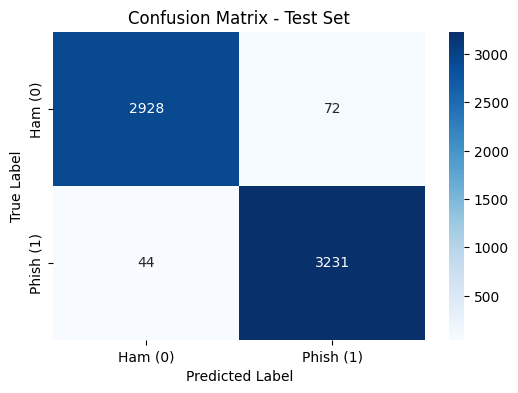

In [20]:
if best_model_rf is not None and X_test is not None and y_test is not None:
    print("Evaluating model on the test set (X_test, y_test)...")
    y_test_pred_rf = best_model_rf.predict(X_test)

    # Probabilities for the positive class (for ROC AUC)
    y_test_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

    test_accuracy = accuracy_score(y_test, y_test_pred_rf)
    test_precision = precision_score(y_test, y_test_pred_rf, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred_rf, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred_rf, zero_division=0)

    try:
        test_roc_auc = roc_auc_score(y_test, y_test_proba_rf)

    # May occur if only one class present in y_true (shouldn't happen with proper split)
    except ValueError:
        test_roc_auc = float('nan')
        print("Warning: ROC AUC score could not be computed (possibly only one class in y_test predictions or true values).")


    print(f"\n--- Test Set Evaluation Metrics (Random Forest) ---")
    print(f"Accuracy:  {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f} (Phishing)")
    print(f"Recall:    {test_recall:.4f} (Phishing)")
    print(f"F1-score:  {test_f1:.4f} (Phishing)")
    print(f"ROC AUC:   {test_roc_auc:.4f}")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred_rf, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_test_pred_rf)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham (0)', 'Phish (1)'], yticklabels=['Ham (0)', 'Phish (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

else:
    print("Model not trained or test data not available. Skipping test set evaluation.")

## 6 Save trained model

Save the final trained model (`best_model_rf`) for later use (e.g., for XAI, making predictions on new data, or evaluating on other test sets).

In [21]:
if best_model_rf is not None:
    MODEL_FILENAME = 'phishing_random_forest_model.joblib'

    try:
        joblib.dump(best_model_rf, MODEL_FILENAME)
        print(f"Trained Random Forest model saved to: /content/{MODEL_FILENAME}")

    except Exception as e:
        print(f"Error saving the model: {e}")

else:
    print("No model available to save.")

Trained Random Forest model saved to: /content/phishing_random_forest_model.joblib
